<div style="text-align: center;">

# Gridding gravmag data with

<img src="https://www.fatiando.org/harmonica/latest/_static/readme-banner.png" style="width: 60%">

## [Lightning Talk at Transform 2020](https://transform2020.sched.com/)

## by [Santiago Soler](https://santisoler.github.io/)
    
<p style="text-align: center;">
CONICET, Argentina |
Universidad Nacional de San Juan, Argentina
</p>
    
</div>


## Introduction

[Harmonica](https://www.fatiando.org/harmonica), part of the [Fatiando a Terra](https://www.fatiando.org) project has some classes for **gridding gravity and magnetic** data through the **Equivalent Layer** technique (a.k.a as equivalent sources).

### Equivalent Layer

The equivalent layer technique consists:
1. Defining a set of **sources** that generates the same gravity or magnetic field that has been meassured,
2. and then use these **sources** to **predict** the desired field on a regular **grid** of points.

<img src="images/eql_draws.png" style="width: 40%">

Import some libraries...

In [1]:
import pyproj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

...and some [Fatiando a Terra](https://www.fatiando.org/) libraries as well.

In [2]:
import boule as bl
import verde as vd
import harmonica as hm

Configure figures DPI so they can look better on the presentation

In [3]:
from matplotlib import rcParams
rcParams["figure.dpi"] = 120

## Get South Africa gravity data

Fetch the sample gravity data from South Africa (the original data is available through [NOAA website](https://www.ngdc.noaa.gov/mgg/gravity/1999/data/regional/africa/)).

Under the hood, [**Pooch**](https://www.fatiando.org/pooch) handles the download and caching the files.

In [4]:
data = hm.datasets.fetch_south_africa_gravity()

In [5]:
data

,latitude,longitude,elevation,gravity
0,-34.39150,17.71900,-589.0,979724.79
1,-34.48000,17.76100,-495.0,979712.90
2,-34.35400,17.77433,-406.0,979725.89
3,-34.13900,17.78500,-267.0,979701.20
4,-34.42200,17.80500,-373.0,979719.00
...,...,...,...,...
14554,-17.95833,21.22500,1053.1,978182.09
14555,-17.98333,21.27500,1033.3,978183.09
14556,-17.99166,21.70833,1041.8,978182.69
14557,-17.95833,21.85000,1033.3,978193.18


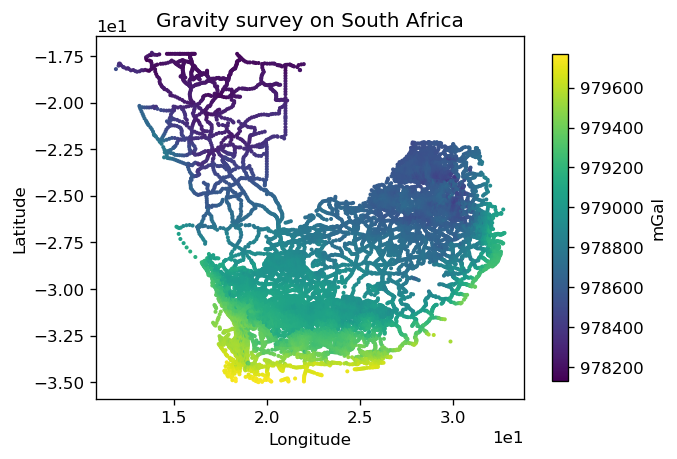

In [6]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=2)
plt.gca().set_aspect("equal") # use the same scale on both longitude and latitude axes
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.colorbar(tmp, shrink=0.9, label="mGal")
plt.title("Gravity survey on South Africa")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Downsample the data

Downsample the data using a blocked mean to speed-up the computations
for this example. This is preferred over simply discarding points to avoid
aliasing effects.

[**Verde**](https://www.fatiando.org/verde) offers great tools for manipulating and preprocessing data.

In [7]:
blocked_mean = vd.BlockReduce(np.mean, spacing=0.2, drop_coords=False)
(longitude, latitude, elevation), gravity_data = blocked_mean.filter(
    (data.longitude, data.latitude, data.elevation), data.gravity,
)

data = pd.DataFrame(
    {"longitude": longitude, "latitude": latitude, "gravity": gravity_data, "elevation": elevation}
)

In [8]:
data

,longitude,latitude,gravity,elevation
0,18.154500,-34.890340,979734.600000,-1038.000
1,18.331665,-34.890335,979765.025000,-477.000
2,19.299585,-34.832660,979726.950000,0.000
3,19.427479,-34.882429,979740.335714,0.000
4,19.595495,-34.939500,979749.250000,0.000
...,...,...,...,...
3390,15.850664,-17.424998,978168.890000,1103.140
3391,16.020830,-17.390000,978169.965000,1108.325
3392,16.140000,-17.390000,978168.790000,1112.500
3393,18.441665,-17.437495,978157.390000,1113.900


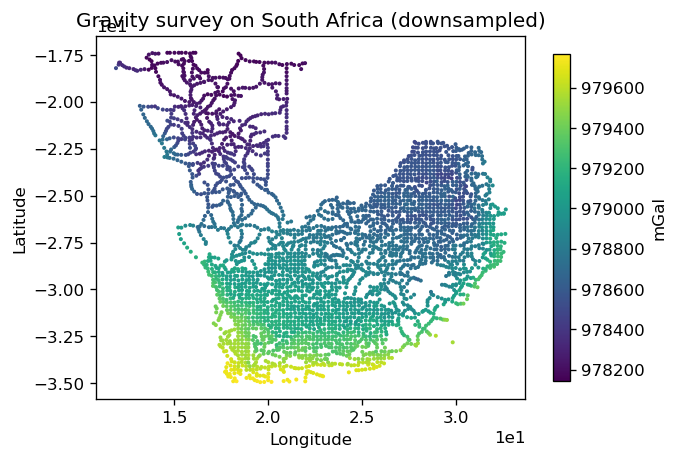

In [9]:
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=2)
plt.gca().set_aspect("equal") # use the same scale on both longitude and latitude axes
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.colorbar(tmp, shrink=0.9, label="mGal")
plt.title("Gravity survey on South Africa (downsampled)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Compute gravity disturbance

Gravity disturbance can be computed as the difference between the observed gravity and the normal gravity on the observation points.
The normal gravity at any latitude and height can be computed through closed-form formula [(Li and Götze, 2001)](https://doi.org/10.1190/1.1487109).

We use [**Boule**](https://www.fatiando.org/boule/latest/) for computing the normal gravity:

In [10]:
ellipsoid = bl.WGS84

In [11]:
data["gravity_disturbance"] = data.gravity - ellipsoid.normal_gravity(data.latitude, data.elevation)

In [12]:
data

,longitude,latitude,gravity,elevation,gravity_disturbance
0,18.154500,-34.890340,979734.600000,-1038.000,-310.137368
1,18.331665,-34.890335,979765.025000,-477.000,-106.505487
2,19.299585,-34.832660,979726.950000,0.000,7.544608
3,19.427479,-34.882429,979740.335714,0.000,16.711542
4,19.595495,-34.939500,979749.250000,0.000,20.784635
...,...,...,...,...,...
3390,15.850664,-17.424998,978168.890000,1103.140,13.672311
3391,16.020830,-17.390000,978169.965000,1108.325,18.149462
3392,16.140000,-17.390000,978168.790000,1112.500,18.262780
3393,18.441665,-17.437495,978157.390000,1113.900,4.848344


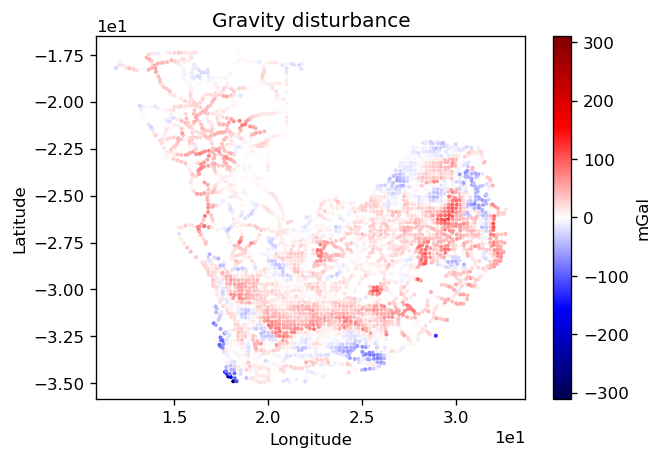

In [13]:
# Compute maximum absolute value of gravity disturbance
# so we can plot a colormap centered on zero.
maxabs = vd.maxabs(data.gravity_disturbance)

tmp = plt.scatter(
    data.longitude,
    data.latitude,
    c=data.gravity_disturbance,
    s=2,
    cmap="seismic",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")  # use the same scale on both longitude and latitude axes
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.colorbar(tmp, label="mGal")
plt.title("Gravity disturbance")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Project coordinates

The `harmonica.EQLHarmonic` gridder works with data defined in Cartesian coordinate system, so we need to project the data before actually try gridding it.
The projection can be achieved through [`pyproj`](https://pyproj4.github.io/pyproj/stable/).

Harmonica also has equivalent layer gridders for spherical coordinates and we hope to have geodetic gridders in the future ([#154](https://github.com/fatiando/harmonica/issues/154)). But we will keep with Cartesian gridders for simplicity.

In [14]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())

In [15]:
projection(data.longitude.values, data.latitude.values)

(array([1794920.23673635, 1812436.39216566, 1908133.83332581, ...,
        1595748.3059806 , 1823312.00019899, 1833198.4222471 ]),
 array([-3663244.96090501, -3663244.36094723, -3656326.29673045, ...,
        -1735020.73121292, -1739912.06194996, -1749785.67632276]))

In [16]:
data["easting"], data["northing"] = projection(data.longitude.values, data.latitude.values)

In [17]:
data

,longitude,latitude,gravity,elevation,gravity_disturbance,easting,northing
0,18.154500,-34.890340,979734.600000,-1038.000,-310.137368,1.794920e+06,-3.663245e+06
1,18.331665,-34.890335,979765.025000,-477.000,-106.505487,1.812436e+06,-3.663244e+06
2,19.299585,-34.832660,979726.950000,0.000,7.544608,1.908134e+06,-3.656326e+06
3,19.427479,-34.882429,979740.335714,0.000,16.711542,1.920779e+06,-3.662296e+06
4,19.595495,-34.939500,979749.250000,0.000,20.784635,1.937390e+06,-3.669146e+06
...,...,...,...,...,...,...,...
3390,15.850664,-17.424998,978168.890000,1103.140,13.672311,1.567142e+06,-1.738625e+06
3391,16.020830,-17.390000,978169.965000,1108.325,18.149462,1.583966e+06,-1.735021e+06
3392,16.140000,-17.390000,978168.790000,1112.500,18.262780,1.595748e+06,-1.735021e+06
3393,18.441665,-17.437495,978157.390000,1113.900,4.848344,1.823312e+06,-1.739912e+06


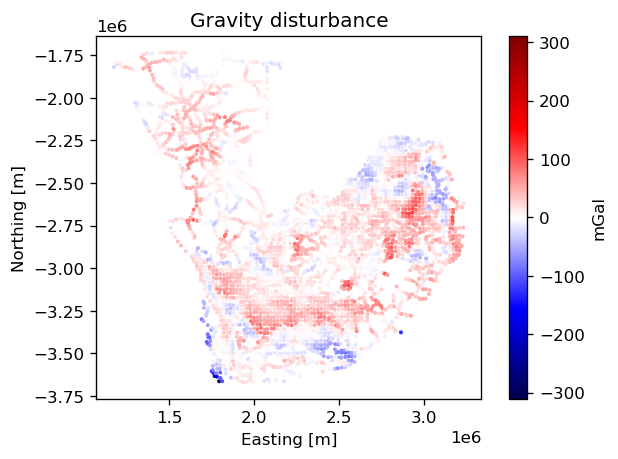

In [18]:
maxabs = vd.maxabs(data.gravity_disturbance)

tmp = plt.scatter(
    data.easting,
    data.northing,
    c=data.gravity_disturbance,
    s=2,
    cmap="seismic",
    vmin=-maxabs,
    vmax=maxabs,
)
plt.gca().set_aspect("equal")  # use the same scale on both easting and northing axes
plt.colorbar(tmp, label="mGal")
plt.title("Gravity disturbance")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.show()

## Grid data using Equivalent Layer

Let's grid the data using Equivalent Layer technique.

First we need to initialize the gridder and fit it with our data.
Let's use some random values for the `relative_depth` and `damping` parameters  for now.

In [45]:
# Define a coordinates tuple for reducing code in the future
coordinates = (data.easting.values, data.northing.values, data.elevation.values)

gridder = hm.EQLHarmonic(relative_depth=100e3, damping=1e-1)
gridder.fit(coordinates, data.gravity_disturbance)

EQLHarmonic(damping=0.1, relative_depth=100000.0)

Use the gridder to predict gravity disturbance values on a regular grid at a constant height. We can set the grid slightly above the maximum observation height.

In [46]:
print("Maximum observation height:", data.elevation.max())

Maximum observation height: 2386.56


In [52]:
upward = 2500
grid_spacing = 5e3
gridder.extra_coords_name = "upward"

grid = gridder.grid(spacing=grid_spacing, extra_coords=upward, data_names=["gravity_disturbance"])

In [48]:
grid

<xarray.Dataset>
Dimensions:              (easting: 412, northing: 388)
Coordinates:
  * easting              (easting) float64 1.177e+06 1.182e+06 ... 3.231e+06
  * northing             (northing) float64 -3.669e+06 -3.664e+06 ... -1.735e+06
    upward               (northing, easting) float64 2.5e+03 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 -29.32 -29.67 ... -0.1646
Attributes:
    metadata:  Generated by EQLHarmonic(damping=0.1, relative_depth=100000.0)

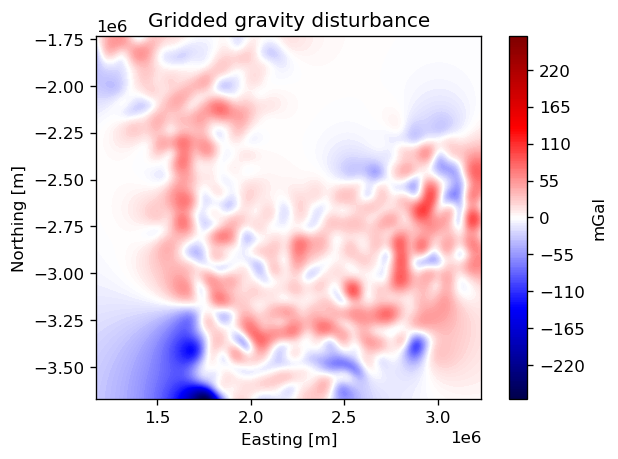

In [49]:
tmp = grid.gravity_disturbance.plot.contourf(levels=250, cmap="seismic", add_colorbar=False)
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.title("Gridded gravity disturbance")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.show()

We can see that the gridder is not reproducing the high frequencies very well.
It can surely be improved by choosing another set of parameters.

## Get a better grid using Cross Validation

We can perform a grid search in order to get a better set of parameters.
This can be achieved through cross-validation: we can score the prediction by splitting the data into a `train` and a `test` sets.
The `train` set is used to fit the gridder and then score it by comparing the predictions versus the `test` set.

See the [Transform2020 Tutorial: From scattered data to gridded products using Verde](https://transform2020.sched.com/event/c7KE/tutorial-from-scattered-data-to-gridded-products-using-verde) for more information about scoring gridders and cross validation.

Let's define a set of parameters that will form a parameters space, and combine them using `itertools`.

In [24]:
import itertools

dampings = [1e-2, 1e-1, 1e0, 1e1]
depths = [10e3, 20e3, 30e3, 40e3]

parameters_sets = [
    dict(damping=combo[0], relative_depth=combo[1])
    for combo in itertools.product(dampings, depths)
]

`parameters_sets` store all possible combinations of given parameters.

In [25]:
parameters_sets

[{'damping': 0.01, 'relative_depth': 10000.0},
 {'damping': 0.01, 'relative_depth': 20000.0},
 {'damping': 0.01, 'relative_depth': 30000.0},
 {'damping': 0.01, 'relative_depth': 40000.0},
 {'damping': 0.1, 'relative_depth': 10000.0},
 {'damping': 0.1, 'relative_depth': 20000.0},
 {'damping': 0.1, 'relative_depth': 30000.0},
 {'damping': 0.1, 'relative_depth': 40000.0},
 {'damping': 1.0, 'relative_depth': 10000.0},
 {'damping': 1.0, 'relative_depth': 20000.0},
 {'damping': 1.0, 'relative_depth': 30000.0},
 {'damping': 1.0, 'relative_depth': 40000.0}]

For each set of parameters we can apply cross-validation to score the gridder.
We can use [Dask](https://dask.org/) to distrubute the computation, run it in parallel and make it faster.

In [26]:
gridder = hm.EQLHarmonic()
cross_validator = vd.BlockKFold(spacing=100e3, random_state=0)

scores_delayed = []
for parameters in parameters_sets:
    gridder.set_params(**parameters)
    score = np.mean(vd.cross_val_score(gridder, coordinates, data.gravity_disturbance, cv=cross_validator, delayed=True))
    scores_delayed.append(score)

No computation have been carried out yet, we need to tell dask to actually compute the tasks we planed. This tasks can be computationally demanding and may require too much RAM if the data has too many points. For a few thousand points, you can run it on your laptop.

In [27]:
import dask
scores = dask.compute(*scores_delayed)

Now we can use the set of parameters that achieves the best score to grid our data.

In [50]:
best = np.argmax(scores)
best_parameters = parameters_sets[best]
print("Best score:", scores[best])
print("Best parameters:", best_parameters)

Best score: 0.13177450148861364
Best parameters: {'damping': 1.0, 'relative_depth': 20000.0}


In [53]:
gridder = hm.EQLHarmonic(**best_parameters)
gridder.fit(coordinates, data.gravity_disturbance)

gridder.extra_coords_name = "upward"
grid = gridder.grid(spacing=grid_spacing, extra_coords=upward, data_names=["gravity_disturbance"])

In [54]:
grid

<xarray.Dataset>
Dimensions:              (easting: 412, northing: 388)
Coordinates:
  * easting              (easting) float64 1.177e+06 1.182e+06 ... 3.231e+06
  * northing             (northing) float64 -3.669e+06 -3.664e+06 ... -1.735e+06
    upward               (northing, easting) float64 2.5e+03 2.5e+03 ... 2.5e+03
Data variables:
    gravity_disturbance  (northing, easting) float64 -3.569 -3.649 ... 3.201
Attributes:
    metadata:  Generated by EQLHarmonic(damping=1.0, relative_depth=20000.0)

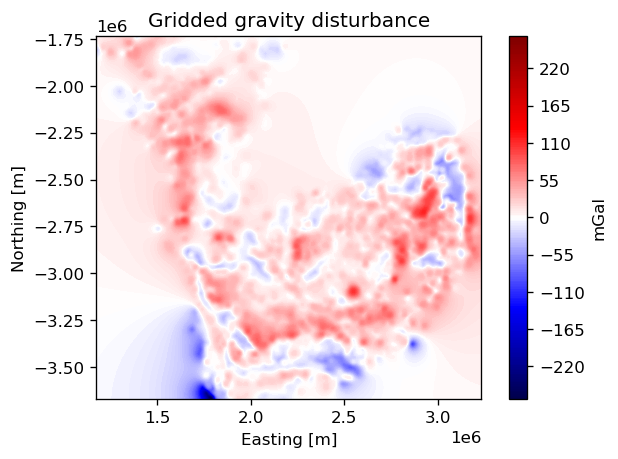

In [55]:
tmp = grid.gravity_disturbance.plot.contourf(levels=250, cmap="seismic", add_colorbar=False)
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.title("Gridded gravity disturbance")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.show()

We can use Verde to mask those grid points that are too far from the data points

In [56]:
masked_grid = vd.distance_mask(coordinates[:2], maxdist=70e3, grid=grid)

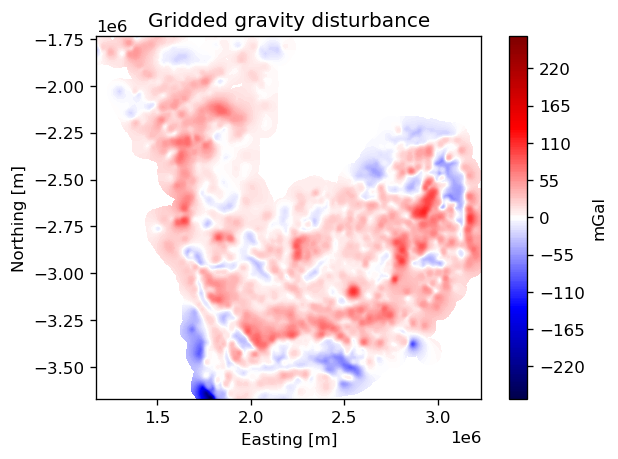

In [57]:
tmp = masked_grid.gravity_disturbance.plot.contourf(levels=250, cmap="seismic", add_colorbar=False)
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.title("Gridded gravity disturbance")
plt.xlabel("Easting [m]")
plt.ylabel("Northing [m]")
plt.show()

We can see that this grid accurately reproduces the high frecuencies of the original data.

### Get a profile out of the Equivalent Layer model

We can use the already fitted equivalent layer model for extracting a profile.
So, instead of interpolating the grid on profile points, we can actually use the equivalent layer model to predict the gravity disturbance on those profile points.

In [61]:
point1 = (2.75e6, -2.75e6)
point2 = (3.2e6, -2.5e6)

profile = gridder.profile(point1, point2, size=250, extra_coords=upward, data_names=["gravity_disturbance"])

In [62]:
profile

,northing,easting,distance,upward,gravity_disturbance
0,-2.750000e+06,2.750000e+06,0.000000,2500.0,31.781157
1,-2.748996e+06,2.751807e+06,2067.395611,2500.0,31.374945
2,-2.747992e+06,2.753614e+06,4134.791221,2500.0,30.923023
3,-2.746988e+06,2.755422e+06,6202.186832,2500.0,30.447948
4,-2.745984e+06,2.757229e+06,8269.582443,2500.0,29.975685
...,...,...,...,...,...
245,-2.504016e+06,3.192771e+06,506511.924607,2500.0,25.699994
246,-2.503012e+06,3.194578e+06,508579.320217,2500.0,25.617734
247,-2.502008e+06,3.196386e+06,510646.715828,2500.0,25.482866
248,-2.501004e+06,3.198193e+06,512714.111439,2500.0,25.302430


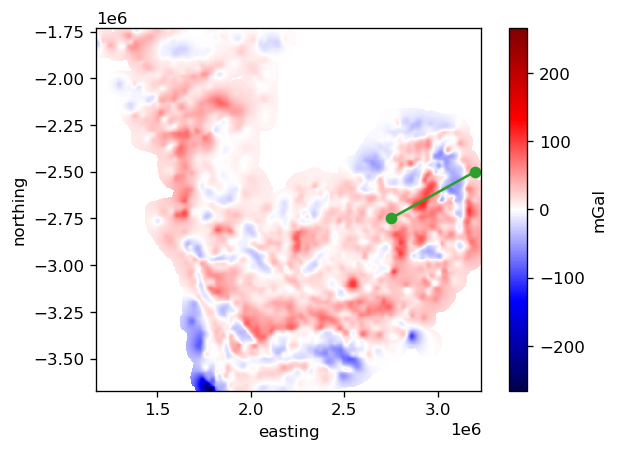

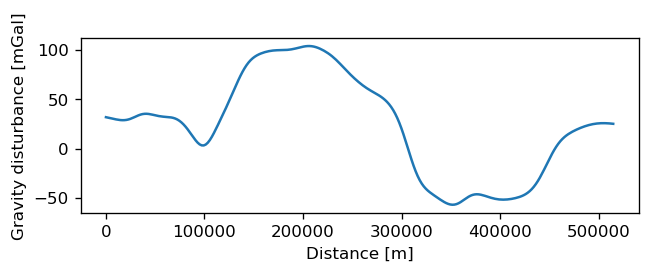

In [74]:
tmp = masked_grid.gravity_disturbance.plot.pcolormesh(cmap="seismic", add_colorbar=False)
plt.plot((point1[0], point2[0]), (point1[1], point2[1]), c="C2", marker="o")
plt.gca().ticklabel_format(style="sci", scilimits=(0, 0))
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

plt.plot(profile.distance, profile.gravity_disturbance)
plt.gca().set_aspect(1000)
plt.ylabel("Gravity disturbance [mGal]")
plt.xlabel("Distance [m]")
plt.show()